# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [ ]:
# Dataset and model path
DATASET_PATH = "/home/ubuntu/Desktop/Ra/datasets/Ra_128_indexed_decimal_2.h5"
MODEL_PATH = "/home/ubuntu/Desktop/Ra/models/VGG16_128_regression_decimal_2.pth"
OUTPUT_PATH = "/home/ubuntu/Desktop/Ra/outputs/VGG16_128_regression_decimal_2.csv"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 200
LR = 1e-4
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 10

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path
if not os.path.exists(os.path.dirname(MODEL_PATH)):
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    print(f"Make new directory {os.path.dirname(MODEL_PATH)}")

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images, and normalize the pixel values.

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Image standardization
mean = images.mean(dim=[0, 2, 3], keepdim=True)
std = images.std(dim=[0, 2, 3], keepdim=True)
images = (images - mean) / std

# Label normalization
labels = (labels - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)
print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [6]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_3884/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_3884/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_3884/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_3884/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [7]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 200] [Train Loss 0.088339 (MSE)] [Valid Loss 0.025434 (MSE)] [Learning Rate: 0.0001]


[Epoch 2 / 200] [Train Loss 0.022436 (MSE)] [Valid Loss 0.020930 (MSE)] [Learning Rate: 0.0001]


[Epoch 3 / 200] [Train Loss 0.015985 (MSE)] [Valid Loss 0.018493 (MSE)] [Learning Rate: 0.0001]


[Epoch 4 / 200] [Train Loss 0.012826 (MSE)] [Valid Loss 0.016965 (MSE)] [Learning Rate: 0.0001]


[Epoch 5 / 200] [Train Loss 0.010582 (MSE)] [Valid Loss 0.009637 (MSE)] [Learning Rate: 0.0001]


[Epoch 6 / 200] [Train Loss 0.009667 (MSE)] [Valid Loss 0.009394 (MSE)] [Learning Rate: 0.0001]


[Epoch 7 / 200] [Train Loss 0.008134 (MSE)] [Valid Loss 0.007945 (MSE)] [Learning Rate: 0.0001]


[Epoch 8 / 200] [Train Loss 0.007408 (MSE)] [Valid Loss 0.007738 (MSE)] [Learning Rate: 0.0001]


[Epoch 9 / 200] [Train Loss 0.006601 (MSE)] [Valid Loss 0.011665 (MSE)] [Learning Rate: 0.0001]


[Epoch 10 / 200] [Train Loss 0.006085 (MSE)] [Valid Loss 0.004448 (MSE)] [Learning Rate: 0.0001]


[Epoch 11 / 200] [Train Loss 0.006213 (MSE)] [Valid Loss 0.008710 (MSE)] [Learning Rate: 0.0001]


[Epoch 12 / 200] [Train Loss 0.005595 (MSE)] [Valid Loss 0.012725 (MSE)] [Learning Rate: 0.0001]


[Epoch 13 / 200] [Train Loss 0.005665 (MSE)] [Valid Loss 0.006762 (MSE)] [Learning Rate: 0.0001]


[Epoch 14 / 200] [Train Loss 0.005408 (MSE)] [Valid Loss 0.005240 (MSE)] [Learning Rate: 0.0001]


[Epoch 15 / 200] [Train Loss 0.004892 (MSE)] [Valid Loss 0.007065 (MSE)] [Learning Rate: 0.0001]


[Epoch 16 / 200] [Train Loss 0.004789 (MSE)] [Valid Loss 0.006816 (MSE)] [Learning Rate: 0.0001]


[Epoch 17 / 200] [Train Loss 0.003736 (MSE)] [Valid Loss 0.006080 (MSE)] [Learning Rate: 5e-05]


[Epoch 18 / 200] [Train Loss 0.003431 (MSE)] [Valid Loss 0.008885 (MSE)] [Learning Rate: 5e-05]


[Epoch 19 / 200] [Train Loss 0.003261 (MSE)] [Valid Loss 0.004856 (MSE)] [Learning Rate: 5e-05]


[Epoch 20 / 200] [Train Loss 0.003203 (MSE)] [Valid Loss 0.005986 (MSE)] [Learning Rate: 5e-05]


[Epoch 21 / 200] [Train Loss 0.003150 (MSE)] [Valid Loss 0.004681 (MSE)] [Learning Rate: 5e-05]


[Epoch 22 / 200] [Train Loss 0.002998 (MSE)] [Valid Loss 0.004930 (MSE)] [Learning Rate: 5e-05]


[Epoch 23 / 200] [Train Loss 0.002603 (MSE)] [Valid Loss 0.003796 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 24 / 200] [Train Loss 0.002445 (MSE)] [Valid Loss 0.004857 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 25 / 200] [Train Loss 0.002375 (MSE)] [Valid Loss 0.004582 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 26 / 200] [Train Loss 0.002360 (MSE)] [Valid Loss 0.004389 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 27 / 200] [Train Loss 0.002308 (MSE)] [Valid Loss 0.005527 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 28 / 200] [Train Loss 0.002329 (MSE)] [Valid Loss 0.006249 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 29 / 200] [Train Loss 0.002222 (MSE)] [Valid Loss 0.006703 (MSE)] [Learning Rate: 2.5e-05]


[Epoch 30 / 200] [Train Loss 0.002098 (MSE)] [Valid Loss 0.004628 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 31 / 200] [Train Loss 0.001928 (MSE)] [Valid Loss 0.004853 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 32 / 200] [Train Loss 0.001985 (MSE)] [Valid Loss 0.006662 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 33 / 200] [Train Loss 0.001875 (MSE)] [Valid Loss 0.004991 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 34 / 200] [Train Loss 0.001892 (MSE)] [Valid Loss 0.004668 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 35 / 200] [Train Loss 0.001800 (MSE)] [Valid Loss 0.005088 (MSE)] [Learning Rate: 1.25e-05]


[Epoch 36 / 200] [Train Loss 0.001753 (MSE)] [Valid Loss 0.004515 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 37 / 200] [Train Loss 0.001650 (MSE)] [Valid Loss 0.004848 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 38 / 200] [Train Loss 0.001613 (MSE)] [Valid Loss 0.004878 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 39 / 200] [Train Loss 0.001669 (MSE)] [Valid Loss 0.005521 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 40 / 200] [Train Loss 0.001668 (MSE)] [Valid Loss 0.005417 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 41 / 200] [Train Loss 0.001612 (MSE)] [Valid Loss 0.005342 (MSE)] [Learning Rate: 6.25e-06]


[Epoch 42 / 200] [Train Loss 0.001563 (MSE)] [Valid Loss 0.005493 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 43 / 200] [Train Loss 0.001524 (MSE)] [Valid Loss 0.005669 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 44 / 200] [Train Loss 0.001507 (MSE)] [Valid Loss 0.005488 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 45 / 200] [Train Loss 0.001478 (MSE)] [Valid Loss 0.005429 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 46 / 200] [Train Loss 0.001522 (MSE)] [Valid Loss 0.005249 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 47 / 200] [Train Loss 0.001460 (MSE)] [Valid Loss 0.005667 (MSE)] [Learning Rate: 3.125e-06]


[Epoch 48 / 200] [Train Loss 0.001467 (MSE)] [Valid Loss 0.005041 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 49 / 200] [Train Loss 0.001418 (MSE)] [Valid Loss 0.005087 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 50 / 200] [Train Loss 0.001446 (MSE)] [Valid Loss 0.004995 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 51 / 200] [Train Loss 0.001447 (MSE)] [Valid Loss 0.005410 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 52 / 200] [Train Loss 0.001457 (MSE)] [Valid Loss 0.004974 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 53 / 200] [Train Loss 0.001404 (MSE)] [Valid Loss 0.005044 (MSE)] [Learning Rate: 1.5625e-06]


[Epoch 54 / 200] [Train Loss 0.001368 (MSE)] [Valid Loss 0.005101 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 55 / 200] [Train Loss 0.001394 (MSE)] [Valid Loss 0.005325 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 56 / 200] [Train Loss 0.001448 (MSE)] [Valid Loss 0.004885 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 57 / 200] [Train Loss 0.001402 (MSE)] [Valid Loss 0.005037 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 58 / 200] [Train Loss 0.001391 (MSE)] [Valid Loss 0.005304 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 59 / 200] [Train Loss 0.001392 (MSE)] [Valid Loss 0.005305 (MSE)] [Learning Rate: 7.8125e-07]


[Epoch 60 / 200] [Train Loss 0.001354 (MSE)] [Valid Loss 0.005037 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 61 / 200] [Train Loss 0.001325 (MSE)] [Valid Loss 0.004963 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 62 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.004964 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 63 / 200] [Train Loss 0.001349 (MSE)] [Valid Loss 0.005045 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 64 / 200] [Train Loss 0.001345 (MSE)] [Valid Loss 0.005076 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 65 / 200] [Train Loss 0.001383 (MSE)] [Valid Loss 0.005230 (MSE)] [Learning Rate: 3.90625e-07]


[Epoch 66 / 200] [Train Loss 0.001366 (MSE)] [Valid Loss 0.005299 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 67 / 200] [Train Loss 0.001394 (MSE)] [Valid Loss 0.005231 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 68 / 200] [Train Loss 0.001368 (MSE)] [Valid Loss 0.005004 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 69 / 200] [Train Loss 0.001336 (MSE)] [Valid Loss 0.005235 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 70 / 200] [Train Loss 0.001390 (MSE)] [Valid Loss 0.005107 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 71 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.005038 (MSE)] [Learning Rate: 1.953125e-07]


[Epoch 72 / 200] [Train Loss 0.001313 (MSE)] [Valid Loss 0.005015 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 73 / 200] [Train Loss 0.001350 (MSE)] [Valid Loss 0.004992 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 74 / 200] [Train Loss 0.001306 (MSE)] [Valid Loss 0.005055 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 75 / 200] [Train Loss 0.001283 (MSE)] [Valid Loss 0.005022 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 76 / 200] [Train Loss 0.001362 (MSE)] [Valid Loss 0.005221 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 77 / 200] [Train Loss 0.001374 (MSE)] [Valid Loss 0.005035 (MSE)] [Learning Rate: 9.765625e-08]


[Epoch 78 / 200] [Train Loss 0.001377 (MSE)] [Valid Loss 0.005056 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 79 / 200] [Train Loss 0.001309 (MSE)] [Valid Loss 0.005093 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 80 / 200] [Train Loss 0.001369 (MSE)] [Valid Loss 0.005060 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 81 / 200] [Train Loss 0.001325 (MSE)] [Valid Loss 0.005080 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 82 / 200] [Train Loss 0.001360 (MSE)] [Valid Loss 0.005107 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 83 / 200] [Train Loss 0.001334 (MSE)] [Valid Loss 0.005112 (MSE)] [Learning Rate: 4.8828125e-08]


[Epoch 84 / 200] [Train Loss 0.001325 (MSE)] [Valid Loss 0.005108 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 85 / 200] [Train Loss 0.001317 (MSE)] [Valid Loss 0.005102 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 86 / 200] [Train Loss 0.001344 (MSE)] [Valid Loss 0.005113 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 87 / 200] [Train Loss 0.001370 (MSE)] [Valid Loss 0.005124 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 88 / 200] [Train Loss 0.001337 (MSE)] [Valid Loss 0.005158 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 89 / 200] [Train Loss 0.001377 (MSE)] [Valid Loss 0.005124 (MSE)] [Learning Rate: 2.44140625e-08]


[Epoch 90 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.005121 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 91 / 200] [Train Loss 0.001375 (MSE)] [Valid Loss 0.005131 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 92 / 200] [Train Loss 0.001346 (MSE)] [Valid Loss 0.005141 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 93 / 200] [Train Loss 0.001312 (MSE)] [Valid Loss 0.005127 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 94 / 200] [Train Loss 0.001361 (MSE)] [Valid Loss 0.005124 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 95 / 200] [Train Loss 0.001368 (MSE)] [Valid Loss 0.005122 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 96 / 200] [Train Loss 0.001350 (MSE)] [Valid Loss 0.005130 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 97 / 200] [Train Loss 0.001330 (MSE)] [Valid Loss 0.005137 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 98 / 200] [Train Loss 0.001331 (MSE)] [Valid Loss 0.005133 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 99 / 200] [Train Loss 0.001408 (MSE)] [Valid Loss 0.005133 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 100 / 200] [Train Loss 0.001321 (MSE)] [Valid Loss 0.005112 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 101 / 200] [Train Loss 0.001340 (MSE)] [Valid Loss 0.005102 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 102 / 200] [Train Loss 0.001333 (MSE)] [Valid Loss 0.005094 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 103 / 200] [Train Loss 0.001372 (MSE)] [Valid Loss 0.005101 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 104 / 200] [Train Loss 0.001283 (MSE)] [Valid Loss 0.005068 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 105 / 200] [Train Loss 0.001291 (MSE)] [Valid Loss 0.005073 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 106 / 200] [Train Loss 0.001382 (MSE)] [Valid Loss 0.005080 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 107 / 200] [Train Loss 0.001328 (MSE)] [Valid Loss 0.005070 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 108 / 200] [Train Loss 0.001331 (MSE)] [Valid Loss 0.005076 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 109 / 200] [Train Loss 0.001406 (MSE)] [Valid Loss 0.005078 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 110 / 200] [Train Loss 0.001376 (MSE)] [Valid Loss 0.005084 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 111 / 200] [Train Loss 0.001333 (MSE)] [Valid Loss 0.005083 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 112 / 200] [Train Loss 0.001338 (MSE)] [Valid Loss 0.005091 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 113 / 200] [Train Loss 0.001370 (MSE)] [Valid Loss 0.005092 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 114 / 200] [Train Loss 0.001369 (MSE)] [Valid Loss 0.005097 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 115 / 200] [Train Loss 0.001363 (MSE)] [Valid Loss 0.005096 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 116 / 200] [Train Loss 0.001285 (MSE)] [Valid Loss 0.005073 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 117 / 200] [Train Loss 0.001303 (MSE)] [Valid Loss 0.005076 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 118 / 200] [Train Loss 0.001369 (MSE)] [Valid Loss 0.005103 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 119 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.005111 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 120 / 200] [Train Loss 0.001321 (MSE)] [Valid Loss 0.005108 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 121 / 200] [Train Loss 0.001321 (MSE)] [Valid Loss 0.005106 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 122 / 200] [Train Loss 0.001390 (MSE)] [Valid Loss 0.005096 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 123 / 200] [Train Loss 0.001348 (MSE)] [Valid Loss 0.005095 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 124 / 200] [Train Loss 0.001393 (MSE)] [Valid Loss 0.005111 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 125 / 200] [Train Loss 0.001342 (MSE)] [Valid Loss 0.005103 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 126 / 200] [Train Loss 0.001319 (MSE)] [Valid Loss 0.005112 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 127 / 200] [Train Loss 0.001358 (MSE)] [Valid Loss 0.005116 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 128 / 200] [Train Loss 0.001327 (MSE)] [Valid Loss 0.005119 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 129 / 200] [Train Loss 0.001335 (MSE)] [Valid Loss 0.005117 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 130 / 200] [Train Loss 0.001334 (MSE)] [Valid Loss 0.005084 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 131 / 200] [Train Loss 0.001339 (MSE)] [Valid Loss 0.005085 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 132 / 200] [Train Loss 0.001385 (MSE)] [Valid Loss 0.005092 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 133 / 200] [Train Loss 0.001351 (MSE)] [Valid Loss 0.005099 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 134 / 200] [Train Loss 0.001289 (MSE)] [Valid Loss 0.005098 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 135 / 200] [Train Loss 0.001328 (MSE)] [Valid Loss 0.005120 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 136 / 200] [Train Loss 0.001317 (MSE)] [Valid Loss 0.005091 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 137 / 200] [Train Loss 0.001402 (MSE)] [Valid Loss 0.005090 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 138 / 200] [Train Loss 0.001371 (MSE)] [Valid Loss 0.005105 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 139 / 200] [Train Loss 0.001357 (MSE)] [Valid Loss 0.005104 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 140 / 200] [Train Loss 0.001270 (MSE)] [Valid Loss 0.005098 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 141 / 200] [Train Loss 0.001326 (MSE)] [Valid Loss 0.005098 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 142 / 200] [Train Loss 0.001419 (MSE)] [Valid Loss 0.005112 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 143 / 200] [Train Loss 0.001328 (MSE)] [Valid Loss 0.005132 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 144 / 200] [Train Loss 0.001347 (MSE)] [Valid Loss 0.005124 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 145 / 200] [Train Loss 0.001353 (MSE)] [Valid Loss 0.005116 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 146 / 200] [Train Loss 0.001321 (MSE)] [Valid Loss 0.005114 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 147 / 200] [Train Loss 0.001332 (MSE)] [Valid Loss 0.005111 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 148 / 200] [Train Loss 0.001321 (MSE)] [Valid Loss 0.005099 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 149 / 200] [Train Loss 0.001358 (MSE)] [Valid Loss 0.005097 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 150 / 200] [Train Loss 0.001295 (MSE)] [Valid Loss 0.005076 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 151 / 200] [Train Loss 0.001341 (MSE)] [Valid Loss 0.005059 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 152 / 200] [Train Loss 0.001305 (MSE)] [Valid Loss 0.005077 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 153 / 200] [Train Loss 0.001332 (MSE)] [Valid Loss 0.005069 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 154 / 200] [Train Loss 0.001339 (MSE)] [Valid Loss 0.005053 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 155 / 200] [Train Loss 0.001355 (MSE)] [Valid Loss 0.005072 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 156 / 200] [Train Loss 0.001334 (MSE)] [Valid Loss 0.005075 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 157 / 200] [Train Loss 0.001330 (MSE)] [Valid Loss 0.005083 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 158 / 200] [Train Loss 0.001303 (MSE)] [Valid Loss 0.005083 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 159 / 200] [Train Loss 0.001399 (MSE)] [Valid Loss 0.005083 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 160 / 200] [Train Loss 0.001367 (MSE)] [Valid Loss 0.005088 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 161 / 200] [Train Loss 0.001298 (MSE)] [Valid Loss 0.005096 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 162 / 200] [Train Loss 0.001332 (MSE)] [Valid Loss 0.005101 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 163 / 200] [Train Loss 0.001284 (MSE)] [Valid Loss 0.005082 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 164 / 200] [Train Loss 0.001338 (MSE)] [Valid Loss 0.005104 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 165 / 200] [Train Loss 0.001355 (MSE)] [Valid Loss 0.005096 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 166 / 200] [Train Loss 0.001330 (MSE)] [Valid Loss 0.005095 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 167 / 200] [Train Loss 0.001372 (MSE)] [Valid Loss 0.005082 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 168 / 200] [Train Loss 0.001319 (MSE)] [Valid Loss 0.005073 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 169 / 200] [Train Loss 0.001347 (MSE)] [Valid Loss 0.005077 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 170 / 200] [Train Loss 0.001286 (MSE)] [Valid Loss 0.005068 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 171 / 200] [Train Loss 0.001362 (MSE)] [Valid Loss 0.005086 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 172 / 200] [Train Loss 0.001375 (MSE)] [Valid Loss 0.005096 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 173 / 200] [Train Loss 0.001328 (MSE)] [Valid Loss 0.005097 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 174 / 200] [Train Loss 0.001362 (MSE)] [Valid Loss 0.005118 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 175 / 200] [Train Loss 0.001342 (MSE)] [Valid Loss 0.005130 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 176 / 200] [Train Loss 0.001359 (MSE)] [Valid Loss 0.005143 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 177 / 200] [Train Loss 0.001325 (MSE)] [Valid Loss 0.005118 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 178 / 200] [Train Loss 0.001316 (MSE)] [Valid Loss 0.005097 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 179 / 200] [Train Loss 0.001351 (MSE)] [Valid Loss 0.005092 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 180 / 200] [Train Loss 0.001314 (MSE)] [Valid Loss 0.005087 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 181 / 200] [Train Loss 0.001312 (MSE)] [Valid Loss 0.005079 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 182 / 200] [Train Loss 0.001348 (MSE)] [Valid Loss 0.005085 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 183 / 200] [Train Loss 0.001390 (MSE)] [Valid Loss 0.005072 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 184 / 200] [Train Loss 0.001329 (MSE)] [Valid Loss 0.005083 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 185 / 200] [Train Loss 0.001340 (MSE)] [Valid Loss 0.005078 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 186 / 200] [Train Loss 0.001333 (MSE)] [Valid Loss 0.005102 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 187 / 200] [Train Loss 0.001309 (MSE)] [Valid Loss 0.005102 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 188 / 200] [Train Loss 0.001323 (MSE)] [Valid Loss 0.005104 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 189 / 200] [Train Loss 0.001318 (MSE)] [Valid Loss 0.005108 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 190 / 200] [Train Loss 0.001337 (MSE)] [Valid Loss 0.005102 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 191 / 200] [Train Loss 0.001323 (MSE)] [Valid Loss 0.005104 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 192 / 200] [Train Loss 0.001340 (MSE)] [Valid Loss 0.005103 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 193 / 200] [Train Loss 0.001326 (MSE)] [Valid Loss 0.005080 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 194 / 200] [Train Loss 0.001370 (MSE)] [Valid Loss 0.005082 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 195 / 200] [Train Loss 0.001332 (MSE)] [Valid Loss 0.005065 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 196 / 200] [Train Loss 0.001344 (MSE)] [Valid Loss 0.005064 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 197 / 200] [Train Loss 0.001374 (MSE)] [Valid Loss 0.005075 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 198 / 200] [Train Loss 0.001341 (MSE)] [Valid Loss 0.005061 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 199 / 200] [Train Loss 0.001317 (MSE)] [Valid Loss 0.005049 (MSE)] [Learning Rate: 1.220703125e-08]


[Epoch 200 / 200] [Train Loss 0.001350 (MSE)] [Valid Loss 0.005088 (MSE)] [Learning Rate: 1.220703125e-08]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

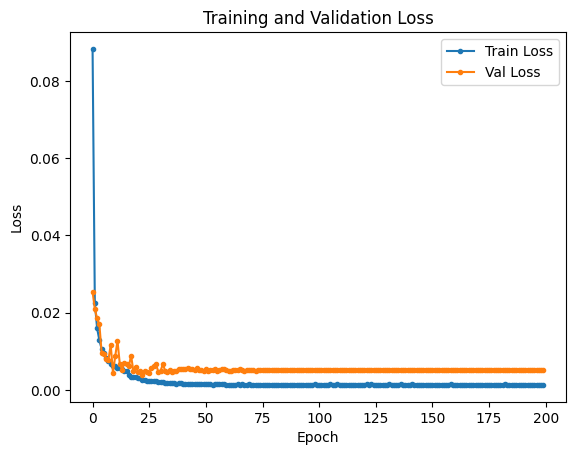

In [8]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [9]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_2.pth


To read the saved data, we can run the following codes:

In [10]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from /home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_2.pth


      Real Labels  Predicted Labels      Diff      MAPE
0            1.75          1.617722 -0.132278  0.924413
1            2.70          2.687999 -0.012001  0.995555
2            1.82          1.913208  0.093208  0.948787
3            2.35          2.177352 -0.172648  0.926533
4            3.90          3.485659 -0.414341  0.893759
...           ...               ...       ...       ...
1834         2.05          1.843706 -0.206294  0.899369
1835         1.76          1.603919 -0.156081  0.911317
1836         2.59          2.798304  0.208304  0.919574
1837         4.09          3.790401 -0.299599  0.926748
1838         2.04          1.746847 -0.293153  0.856298

[1839 rows x 4 columns]
MAPE: 0.9249420151213672


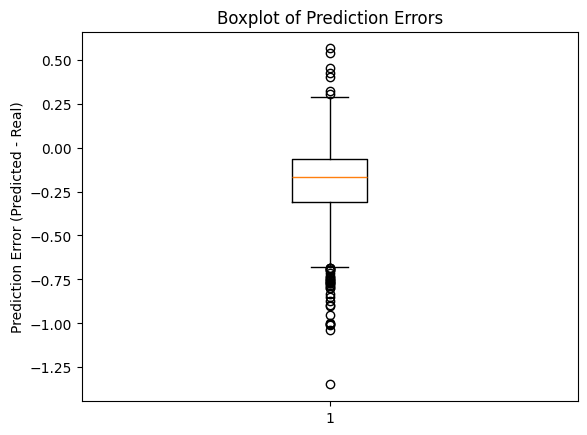

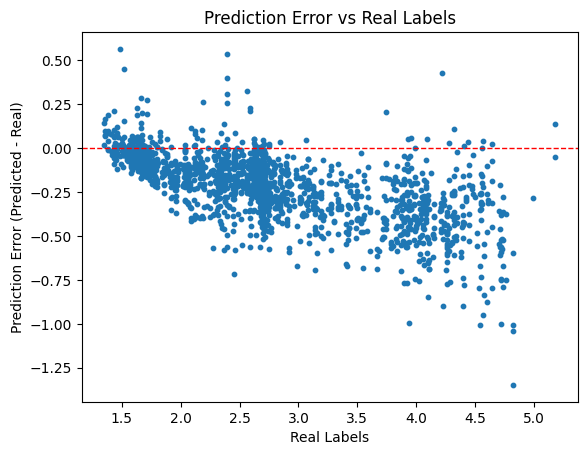

In [11]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = vgg16(images_val_tensor.to(device)).cpu().detach().numpy()

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()